## Проектная работа

### Тема: Сравнение методов распознавания именованных сущностей (NER) без дополнительного обучения

Содержание:
1. Scraping новостного сайта [Nice Matin](https://www.nicematin.com/);

2. Формирование набора данных;

3. Минимальный анализ и предобработка набора данных (EDA & Preprocessing);

4. Применение библиотеки [spaCy](https://spacy.io/models/fr) для распознования именованных сущностей;

5. Распознование именованных сущностей с использованием предобученной модели [Camembert-ner](https://huggingface.co/Jean-Baptiste/camembert-ner-with-dates);

6. Сравнение и итоговые выводы;

In [2]:
from pathlib import Path
from datetime import date

import requests      
import numpy as np   
import pandas as pd  
import time          

from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from tqdm import tqdm

import spacy
from spacy import displacy
from collections import Counter
import fr_core_news_md

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from ipymarkup import show_span_box_markup, show_span_line_markup

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Парсинг

Собирать данные будем на новостном сайте Nice Matin - утренняя Ницца )

In [6]:
top_page = 'https://www.nicematin.com/'

In [7]:
UserAgent().chrome

'Mozilla/5.0 (iPhone; CPU iPhone OS 18_2_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/131.0.6778.73 Mobile/15E148 Safari/604.1'

In [8]:
top_response = requests.get(top_page, headers={'User-Agent': UserAgent().chrome})
top_response

<Response [200]>

In [9]:
top_html = top_response.content

In [10]:
len(top_html)

300888

In [11]:
top_soup = BeautifulSoup(top_html, 'html.parser')

In [12]:
type(top_soup.prettify())

str

In [13]:
print(top_soup.prettify()[:1000])

<!DOCTYPE html>
<html class="nm" lang="fr">
 <head>
  <meta charset="utf-8"/>
  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="icon" type="image/png"/>
  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="shortcut icon" type="image/x-icon"/>
  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon"/>
  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="57x57">
   <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="60x60">
    <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="72x72"/>
    <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="76x76"/>
    <lin

In [14]:
top_soup.html.head.title

<title>Actualités et infos en direct - Nice-Matin</title>

Напишем функцию для получения списка ссылок на странице

In [16]:
def get_links_list (page, tag, class_to_find):
    """
    Parameters:
    page: link to an html-page to find the links on;
    tag: <tag> to find;
    class_to_find: <class> to find; 
    
    Returns: list of links
    """
    response = requests.get(page, headers={'User-Agent': UserAgent().chrome})
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')
    obj_list = soup.find_all(tag, attrs = {'class':class_to_find})
    links_list = [obj_item.attrs['href'] for obj_item in obj_list if obj_item.attrs['href'][0:25] == 'https://www.nicematin.com']
    return links_list

Соберем список тематических ссылок на первой странице Nice matin

In [18]:
theme_links_list = get_links_list(top_page, 'a', 'header-link-secondary')

In [19]:
theme_links_list

['https://www.nicematin.com/sujet/faits-de-societe',
 'https://www.nicematin.com/sujet/faits-divers',
 'https://www.nicematin.com/sujet/economie',
 'https://www.nicematin.com/sujet/politique',
 'https://www.nicematin.com/sujet/sport',
 'https://www.nicematin.com/sujet/sante',
 'https://www.nicematin.com/sujet/ogcnice',
 'https://www.nicematin.com/sujet/opinion',
 'https://www.nicematin.com/sujet/culture',
 'https://www.nicematin.com/sujet/jeux-olympiques',
 'https://www.nicematin.com/ville/nice',
 'https://www.nicematin.com/commune/saint-laurent-du-var',
 'https://www.nicematin.com/ville/cagnes',
 'https://www.nicematin.com/ville/cannes',
 'https://www.nicematin.com/ville/antibes',
 'https://www.nicematin.com/ville/grasse',
 'https://www.nicematin.com/ville/menton',
 'https://www.nicematin.com/ville/monaco',
 'https://www.nicematin.com/ville/vallees']

In [20]:
theme_links_list[0]

'https://www.nicematin.com/sujet/faits-de-societe'

Пройдем по всем тематическим ссылкам и соберем итоговый список ссылок на новостные статьи

In [22]:
allnews_links_list = []

In [23]:
for link in tqdm(theme_links_list):
    allnews_links_list = allnews_links_list + get_links_list(link, 'a', 'title-link')
    time.sleep(0.3)

100%|███████████████████████████████████████████| 19/19 [00:13<00:00,  1.42it/s]


In [24]:
len(allnews_links_list)

294

In [25]:
allnews_links_list[:10]

['https://www.nicematin.com/education/le-premier-college-catholique-hors-contrat-avec-l-etat-va-ouvrir-a-nice-979533',
 'https://www.nicematin.com/faits-de-societe/bayrou-s-exprimera-la-semaine-prochaine-sur-le-debat-etre-francais-979537',
 'https://www.nicematin.com/faits-de-societe/livreurs-de-repas-a-domicile-la-course-aux-profits-des-plateformes-fait-derailler-leur-sante-979535',
 'https://www.nicematin.com/faits-de-societe/120-jours-par-an-c-est-fini-une-nouvelle-commune-des-alpes-maritimes-durcit-les-regles-des-locations-airbnb-979432',
 'https://www.nicematin.com/justice/consentement-le-texte-modifiant-la-definition-penale-du-viol-debattu-a-l-assemblee-979508',
 'https://www.nicematin.com/education/sexisme-mixite-stereotypes-persistants-on-parle-d-egalite-aux-eleves-de-ce-college-de-mouans-sartoux-979375',
 'https://www.nicematin.com/education/ces-collegiens-de-menton-sont-en-finale-du-concours-du-court-metrage-prix-philoxenia-979358',
 'https://www.nicematin.com/faits-de-societ

Посмотрим на первую ссылку в списке

In [27]:
allnews_links_list[0]

'https://www.nicematin.com/education/le-premier-college-catholique-hors-contrat-avec-l-etat-va-ouvrir-a-nice-979533'

попробуем получить детальную информацию по новости

In [29]:
response = requests.get(allnews_links_list[0], headers={'User-Agent': UserAgent().chrome})

In [30]:
response

<Response [200]>

In [31]:
html = response.content

In [32]:
soup = BeautifulSoup(html, 'html.parser')

In [33]:
soup.prettify()[:1000]

'<!DOCTYPE html>\n<html class="nm" lang="fr">\n <head>\n  <meta charset="utf-8"/>\n  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="icon" type="image/png"/>\n  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="shortcut icon" type="image/x-icon"/>\n  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon"/>\n  <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="57x57">\n   <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="60x60">\n    <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="72x72"/>\n    <link href="https://cdn.assets03.nicematin.com/build/favicons/freemium/nm_fav.d9370e02.png" rel="apple-touch-icon" sizes="76x76"

In [34]:
title = soup.find('h1', attrs = {'class':"article-title"}).text
title

"À Nice, le premier collège catholique hors contrat avec l'État va bientôt ouvrir"

In [35]:
excerpt = soup.find('h2', attrs = {'class':"article-excerpt"}).text.strip('\r\n ')
excerpt

'Premier établissement de ce type en ville, le collège Saint-François ouvrira en septembre. Assumant "une foi enracinée", la cofondatrice se défend de tout intégrisme.'

In [36]:
author = soup.find('span', attrs = {'class':"author"})
if author: author = author.text
author

'Alexandre Ori (aori@nicematin.fr)'

In [37]:
published = soup.find('span', attrs = {'class':"published-at"})
if published: published = published.text
published

'Publié le 26/03/2025 à 14:15, mis à jour le 26/03/2025 à 14:31'

In [38]:
city = soup.find('a', attrs = {'class':"blue city"})
if city: city = city.text
city

'Nice'

In [39]:
full_text = soup.find('section', attrs = {'class':"article-block", 'id':'full-text'})
if full_text: full_text = full_text.text.strip('\ncommentaires ')
full_text

'Les couloirs de l’aumônerie vivent leurs derniers mois de tranquillité. Bientôt, des dizaines de bambins égaieront les salles paroissiales de l’église Saint-Joseph, à Nice, au 21, rue Smolett. Là où le futur collège catholique Saint-François prendra ses quartiers pour une première rentrée en septembre 2025.\nL’établissement privé, hors contrat avec l’État, ouvrira une classe de 6e puis une classe par an et par niveau supplémentaire jusqu’à la 3e. Sa cofondatrice Alicia Colson répond aux questions de Nice-Matin.\nIl existe déjà six collèges catholiques à Nice. Tous sont sous contrat avec l’État. Pourquoi en créer un nouveau, hors contrat?\nPour plusieurs raisons. Déjà, parce que dans ces autres établissements, les enfants sont plus d’une trentaine par classe. Ici, ils seront vingt-cinq max. Les téléphones seront déposés le matin et rendus le soir. Ensuite, parce que je souhaite aller plus loin dans les programmes: le latin sera obligatoire dès la 6e et il y aura beaucoup plus d’anglais

Напишем функцию, возвращающую информацию из новости (title, author, published, region, excerpt, full_text) по url

In [41]:
def getNewsData (nlink):
    
    response = requests.get(nlink, headers={'User-Agent': UserAgent().chrome})
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')

    title = soup.find('h1', attrs = {'class':"article-title"})
    if title: title = title.text

    author = soup.find('span', attrs = {'class':"author"})
    if author: author = author.text
    
    published = soup.find('span', attrs = {'class':"published-at"})
    if published: published = published.text

    city = soup.find('a', attrs = {'class':"blue city"})
    if city: city = city.text
    
    excerpt = soup.find('h2', attrs = {'class':"article-excerpt"})
    if excerpt: excerpt = excerpt.text.strip('\r\n ')

    full_text = soup.find('section', attrs = {'class':"article-block", 'id':'full-text'})
    if full_text: full_text = full_text.text.strip('\ncommentaires ')

    data_row = {'Title':title, 'Author':author, 'Published':published, 'Region':city,
                'Excerpt':excerpt, 'Full_text':full_text}   
    
    return data_row

In [42]:
allnews_links_list[0]

'https://www.nicematin.com/education/le-premier-college-catholique-hors-contrat-avec-l-etat-va-ouvrir-a-nice-979533'

In [43]:
data_row = getNewsData(allnews_links_list[0])

In [44]:
data_row

{'Title': "À Nice, le premier collège catholique hors contrat avec l'État va bientôt ouvrir",
 'Author': 'Alexandre Ori (aori@nicematin.fr)',
 'Published': 'Publié le 26/03/2025 à 14:15, mis à jour le 26/03/2025 à 14:31',
 'Region': 'Nice',
 'Excerpt': 'Premier établissement de ce type en ville, le collège Saint-François ouvrira en septembre. Assumant "une foi enracinée", la cofondatrice se défend de tout intégrisme.',
 'Full_text': 'Les couloirs de l’aumônerie vivent leurs derniers mois de tranquillité. Bientôt, des dizaines de bambins égaieront les salles paroissiales de l’église Saint-Joseph, à Nice, au 21, rue Smolett. Là où le futur collège catholique Saint-François prendra ses quartiers pour une première rentrée en septembre 2025.\nL’établissement privé, hors contrat avec l’État, ouvrira une classe de 6e puis une classe par an et par niveau supplémentaire jusqu’à la 3e. Sa cofondatrice Alicia Colson répond aux questions de Nice-Matin.\nIl existe déjà six collèges catholiques à Ni

Работает ! Осталось пройти в цикле по всем новостным ссылкам и сохранить полученные данные в pandas dataframe

In [46]:
df_news = pd.DataFrame(columns=['Title', 'Author', 'Published', 'Region','Excerpt', 'Full_text'])

In [47]:
for news_link in tqdm(allnews_links_list):
    data_row = getNewsData(news_link)
    df_news = pd.concat([df_news, pd.DataFrame([data_row])], ignore_index=True)
    time.sleep(0.3)

100%|█████████████████████████████████████████| 294/294 [04:13<00:00,  1.16it/s]


In [48]:
df_news.shape

(294, 6)

In [49]:
df_news.tail()

,Title,Author,Published,Region,Excerpt,Full_text
289,Des habitants réveillés en pleine nuit par un ...,A. R.,"Publié le 18/03/2025 à 20:20, mis à jour le 18...",Vallées,Un incendie involontaire de voitures est surve...,"""J’ai été réveillée à minuit par des bruits d’..."
290,"En cas de séisme, quels sont les bons gestes à...",S.C,"Publié le 18/03/2025 à 20:02, mis à jour le 18...",Région,"Ce mardi 18 mars, un séisme de magnitude 4.1 a...",Une secousse d'une magnitude de l'orde de 6 à ...
291,La température la plus basse de l'hiver a été ...,La rédaction,"Publié le 18/03/2025 à 16:16, mis à jour le 18...",Nice,La station météorologique d'Isola 2000 a enreg...,Il fait froid... mais pas autant qu'on pourrai...
292,Les propriétaires de résidences secondaires so...,La rédaction,"Publié le 17/03/2025 à 19:58, mis à jour le 17...",Vallées,Sous perfusion d'argent public selon un rappor...,"À Isola, entre 650 et 700 âmes vivent à l’anné..."
293,"Culture, gestion des services publics, gouvern...",Alexandre Ori,"Publié le 17/03/2025 à 19:45, mis à jour le 17...",Vallées,"Dans un rapport, la Chambre questionne la gouv...",Peut mieux faire. L’appréciation ne vient pas ...


Сохраним полученный датасет для последующего использования

In [51]:
today = date.today()
filename = './data/Nice-Matin' + '-' + str(today) + '.csv'
filepath = Path(filename)  
filepath.parent.mkdir(parents=True, exist_ok=True)  

In [52]:
df_news.to_csv(filepath, sep='|', index=False)

## EDA

Для повторяемости результатов, загрузим сохраненный датасет 

In [381]:
df_nm = pd.read_csv('data/Nice-Matin-2025-03-28.csv', sep='|')

Посмотрим на общие параметры собранного датасета

In [383]:
df_nm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      294 non-null    object
 1   Author     292 non-null    object
 2   Published  292 non-null    object
 3   Region     292 non-null    object
 4   Excerpt    292 non-null    object
 5   Full_text  294 non-null    object
dtypes: object(6)
memory usage: 13.9+ KB


Видим, что есть две записи с пропущенными значениями - посмотрим на них

In [385]:
df_nm[df_nm.isna().any(axis=1)]

,Title,Author,Published,Region,Excerpt,Full_text
203,3 expériences à vivre au Salon International d...,NaN,NaN,NaN,NaN,1.Des démonstrations inédites de grands chefs\...
211,3 expériences à vivre au Salon International d...,NaN,NaN,NaN,NaN,1.Des démonstrations inédites de grands chefs\...


Записей всего две - удалим их из датасета

In [387]:
df_nm.dropna(inplace = True)

In [388]:
df_nm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 293
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      292 non-null    object
 1   Author     292 non-null    object
 2   Published  292 non-null    object
 3   Region     292 non-null    object
 4   Excerpt    292 non-null    object
 5   Full_text  292 non-null    object
dtypes: object(6)
memory usage: 16.0+ KB


Числовых признаков в наборе данных нет, посмотрим на количество уникальных признаков

In [390]:
df_nm.nunique()

Title        262
Author       120
Published    262
Region        19
Excerpt      259
Full_text    262
dtype: int64

В датасете собраны новости из 19 различных регионов:

In [392]:
df_nm['Region'].unique()

array(['Nice', 'France', 'Cagnes', 'Grasse', 'Menton', 'Monde',
       "Côte d'Azur", 'Cannes', 'Var', 'Antibes', 'Marseille', 'Région',
       'Monaco', 'La Seyne', 'Toulon', 'Draguignan',
       'Fréjus/Saint-Raphaël', 'Hyères', 'Vallées'], dtype=object)

В наборе данных собраны новости от 120 авторов, посмотрим на ряд первых из списка

In [394]:
df_nm['Author'].unique()[:21]

array(['Alexandre Ori (aori@nicematin.fr)', 'AFP',
       'Aurélie Selvi (aselvi@nicematin.fr)', 'La rédaction avec AFP',
       'Delphine Gouaty', 'Rachel Dordor (rdordor@nicematin.fr)',
       'La rédaction', 'Jean Stierlé',
       'Eric Galliano (egalliano@nicematin.fr)', 'C. C avec S.L',
       'A. Ci.', 'Christophe Cirone', 'C. G.', 'M. D', 'Damien Allemand',
       'T.P.', 'G.L. et L.S.', 'Grégory Leclerc', 'K.Wenger', 'S. N.',
       'Marie-Cécile Bérenger'], dtype=object)

## Preprocessing

In [397]:
df_nm.Full_text[3]

'Après Paris, Marseille ou Beausoleil, au tour de Villeneuve-Loubet de limiter plus drastiquement les locations type Airbnb. Jeudi, en conseil municipal, les élus ont voté à l’unanimité l’abaissement du nombre maximal de jours de mise en location d’une résidence principale en meublé de tourisme. Jusqu’alors fixé à 120 jours par an, ce seuil descend à 90. Un durcissement permis par le vote, le 19 novembre 2024, de la loi Le Meur "visant à renforcer les outils de régulation des meublés de tourisme à l’échelle locale". Celle-ci donne, depuis le 1er janvier, les coudées plus franches aux collectivités pour réguler et contrôler.\n\xa0\n\n\n\n\n\n\n\n\n\nLutter contre les nuisances\nLa commune, qui soumet déjà ces locations – en résidence principale comme secondaire – à une déclaration préalable (1), recense 912 meublés de tourisme. "Du propriétaire qui loue dix jours par an à celui qui le fait de manière plus systématique, sur une résidence secondaire, en passant par des professionnels", fo

Видим, что текст содержит множество переносов строк и прочих символов форматирования, поэтому проведем небольшую дополнительную обработку текста и удалим подобные символы.

In [399]:
# Defining a function to clean text from new lines and other formatting symbols
def clean_text(text):
    patterns_list = ["\n", "\r", "\xa0", "\\"]
    cleaned_text = text
    for pattern in patterns_list: 
        cleaned_text = cleaned_text.replace(pattern, "")
    return cleaned_text

In [400]:
## Applying our text-cleaning function to the hole dataset
df_nm['Full_text'] = df_nm['Full_text'].apply(clean_text)

In [401]:
df_nm['Excerpt'] = df_nm['Excerpt'].apply(clean_text)

Посмотрим на результат

In [403]:
df_nm.Full_text[3]

'Après Paris, Marseille ou Beausoleil, au tour de Villeneuve-Loubet de limiter plus drastiquement les locations type Airbnb. Jeudi, en conseil municipal, les élus ont voté à l’unanimité l’abaissement du nombre maximal de jours de mise en location d’une résidence principale en meublé de tourisme. Jusqu’alors fixé à 120 jours par an, ce seuil descend à 90. Un durcissement permis par le vote, le 19 novembre 2024, de la loi Le Meur "visant à renforcer les outils de régulation des meublés de tourisme à l’échelle locale". Celle-ci donne, depuis le 1er janvier, les coudées plus franches aux collectivités pour réguler et contrôler.Lutter contre les nuisancesLa commune, qui soumet déjà ces locations – en résidence principale comme secondaire – à une déclaration préalable (1), recense 912 meublés de tourisme. "Du propriétaire qui loue dix jours par an à celui qui le fait de manière plus systématique, sur une résidence secondaire, en passant par des professionnels", font savoir ses services.La no

Символы форматирования из текста удалены, можно двигаться дальше

## NER с использованием библиотеки spaCy

Поскольку у нас датасет на французском, то воспользуемся библиотекой [spaСy](https://spacy.io/models/fr)

In [407]:
nlp = spacy.load("fr_core_news_md")

In [408]:
text = df_nm.Full_text[3]
text

'Après Paris, Marseille ou Beausoleil, au tour de Villeneuve-Loubet de limiter plus drastiquement les locations type Airbnb. Jeudi, en conseil municipal, les élus ont voté à l’unanimité l’abaissement du nombre maximal de jours de mise en location d’une résidence principale en meublé de tourisme. Jusqu’alors fixé à 120 jours par an, ce seuil descend à 90. Un durcissement permis par le vote, le 19 novembre 2024, de la loi Le Meur "visant à renforcer les outils de régulation des meublés de tourisme à l’échelle locale". Celle-ci donne, depuis le 1er janvier, les coudées plus franches aux collectivités pour réguler et contrôler.Lutter contre les nuisancesLa commune, qui soumet déjà ces locations – en résidence principale comme secondaire – à une déclaration préalable (1), recense 912 meublés de tourisme. "Du propriétaire qui loue dix jours par an à celui qui le fait de manière plus systématique, sur une résidence secondaire, en passant par des professionnels", font savoir ses services.La no

In [409]:
doc = nlp(text)
doc

Après Paris, Marseille ou Beausoleil, au tour de Villeneuve-Loubet de limiter plus drastiquement les locations type Airbnb. Jeudi, en conseil municipal, les élus ont voté à l’unanimité l’abaissement du nombre maximal de jours de mise en location d’une résidence principale en meublé de tourisme. Jusqu’alors fixé à 120 jours par an, ce seuil descend à 90. Un durcissement permis par le vote, le 19 novembre 2024, de la loi Le Meur "visant à renforcer les outils de régulation des meublés de tourisme à l’échelle locale". Celle-ci donne, depuis le 1er janvier, les coudées plus franches aux collectivités pour réguler et contrôler.Lutter contre les nuisancesLa commune, qui soumet déjà ces locations – en résidence principale comme secondaire – à une déclaration préalable (1), recense 912 meublés de tourisme. "Du propriétaire qui loue dix jours par an à celui qui le fait de manière plus systématique, sur une résidence secondaire, en passant par des professionnels", font savoir ses services.La nou

In [410]:
doc.ents

(Paris,
 Marseille,
 Beausoleil,
 Villeneuve-Loubet,
 Airbnb,
 Le Meur,
 nuisancesLa commune,
 Lionnel Luca,
 AG,
 Airbnb,
 Le Meur,
 Le Meur,
 Nice)

In [411]:
len(doc.ents)

13

In [412]:
[(X.text, X.label_) for X in doc.ents]

[('Paris', 'LOC'),
 ('Marseille', 'LOC'),
 ('Beausoleil', 'LOC'),
 ('Villeneuve-Loubet', 'LOC'),
 ('Airbnb', 'ORG'),
 ('Le Meur', 'PER'),
 ('nuisancesLa commune', 'LOC'),
 ('Lionnel Luca', 'PER'),
 ('AG', 'ORG'),
 ('Airbnb', 'ORG'),
 ('Le Meur', 'PER'),
 ('Le Meur', 'PER'),
 ('Nice', 'LOC')]

In [413]:
displacy.render(doc, jupyter=True, style='ent')

In [414]:
len(nlp(text).ents)

13

In [415]:
len(df_nm)

292

In [416]:
spacy_results = []

In [417]:
def populate_spacy_results(text):
    spacy_results.append(len(nlp(text).ents))

In [418]:
df_nm['Full_text'].apply(populate_spacy_results)

0      None
1      None
2      None
3      None
4      None
       ... 
289    None
290    None
291    None
292    None
293    None
Name: Full_text, Length: 292, dtype: object

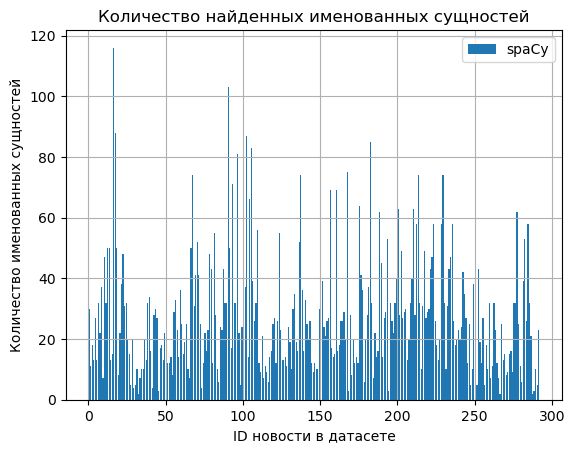

In [419]:
# Visualizing results
x = 0.5 + np.arange(len(df_nm))

plt.bar(x, spacy_results, label='spaCy') ## width=1
plt.title('Количество найденных именованных сущностей')
plt.xlabel('ID новости в датасете')
plt.ylabel('Количество именованных сущностей')
plt.grid(True)
plt.legend()
plt.show()

Результаты использования библиотеки spaCy получены и можно переходить к сравнению с BERT-моделью.

## NER с использованием предобученной модели

В качестве альтернативного варианта используем предобученную для французского языка модель [Camembert-ner](https://huggingface.co/Jean-Baptiste/camembert-ner-with-dates) с сайта Hugging Face

In [423]:
# Loading tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner-with-dates")

In [424]:
# defining huggingface pipleine
camembert = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple", device='cuda', stride=256)

In [425]:
# testing on the same article
out = camembert(text)
out

[{'entity_group': 'LOC',
  'score': 0.9948874,
  'word': 'Paris',
  'start': 5,
  'end': 11},
 {'entity_group': 'LOC',
  'score': 0.9953046,
  'word': 'Marseille',
  'start': 12,
  'end': 22},
 {'entity_group': 'LOC',
  'score': 0.9953244,
  'word': 'Beausoleil',
  'start': 25,
  'end': 36},
 {'entity_group': 'LOC',
  'score': 0.9955947,
  'word': 'Villeneuve-Loubet',
  'start': 48,
  'end': 66},
 {'entity_group': 'MISC',
  'score': 0.8684096,
  'word': 'Airbnb',
  'start': 115,
  'end': 122},
 {'entity_group': 'DATE',
  'score': 0.84749264,
  'word': 'Jeudi, en',
  'start': 123,
  'end': 133},
 {'entity_group': 'DATE',
  'score': 0.9830068,
  'word': 'jours',
  'start': 219,
  'end': 225},
 {'entity_group': 'DATE',
  'score': 0.8953894,
  'word': 'à 120 jours',
  'start': 312,
  'end': 324},
 {'entity_group': 'DATE',
  'score': 0.6327136,
  'word': 'à 90',
  'start': 349,
  'end': 354},
 {'entity_group': 'DATE',
  'score': 0.99246866,
  'word': 'le 19 novembre 2024',
  'start': 391,
 

In [426]:
# we need to get spans in particular format for markup visualization
spans = [(d['start'], d['end'], d['entity_group']) for d in out]
spans

[(5, 11, 'LOC'),
 (12, 22, 'LOC'),
 (25, 36, 'LOC'),
 (48, 66, 'LOC'),
 (115, 122, 'MISC'),
 (123, 133, 'DATE'),
 (219, 225, 'DATE'),
 (312, 324, 'DATE'),
 (349, 354, 'DATE'),
 (391, 411, 'DATE'),
 (418, 430, 'MISC'),
 (543, 558, 'DATE'),
 (835, 845, 'DATE'),
 (1015, 1024, 'DATE'),
 (1468, 1481, 'PER'),
 (1673, 1675, 'MISC'),
 (1676, 1682, 'MISC'),
 (1839, 1851, 'MISC'),
 (2297, 2309, 'MISC'),
 (2404, 2409, 'LOC'),
 (2430, 2451, 'DATE')]

In [427]:
len(out), len(spans)

(21, 21)

In [428]:
show_span_line_markup(text, spans)

Посчитаем количество найденных моделью именованных сущностей для каждой статьи

In [430]:
bert_results = []

In [431]:
def populate_bert_results(text):
    bert_results.append(len(camembert(text)))

In [432]:
df_nm['Full_text'].apply(populate_bert_results)

0      None
1      None
2      None
3      None
4      None
       ... 
289    None
290    None
291    None
292    None
293    None
Name: Full_text, Length: 292, dtype: object

In [433]:
len(bert_results), len(spacy_results)

(292, 292)

и отобразим результаты на диаграмме

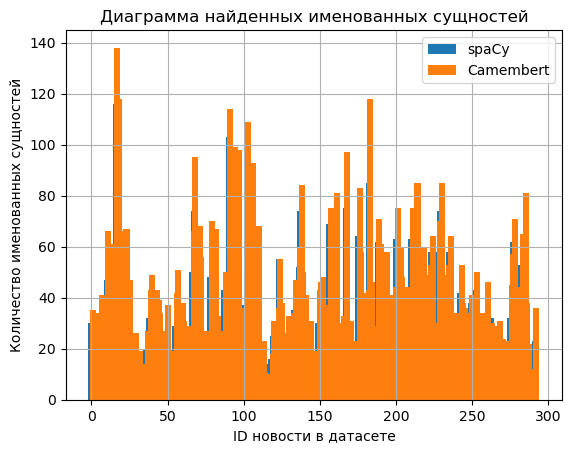

In [435]:
# Visualizing the results
x1 = np.arange(len(df_nm))
x2 = 1 + np.arange(len(df_nm))

plt.bar(x1, spacy_results, width=4, label='spaCy')
plt.bar(x2, bert_results, width=4, label='Camembert') ## width=1
plt.title('Диаграмма найденных именованных сущностей')
plt.xlabel('ID новости в датасете')
plt.ylabel('Количество именованных сущностей')
plt.grid(True)
plt.legend()
plt.show()

## Итоги

1. Оба использованных подхода достаточно хорошо справляются с задачей NER на тексте новостей без дополнительного обучения;
2. BERT-модель демонстрирует лучшие результаты, в основном за счет определения дат, но результаты не идеальны и в ряде случаев модель ошибается;
3. Дообучение модели могло бы повысить качество распознавания, но это потребовало бы совсем других временных и финансовых затрат, в первую очередь, на подготовку и **разметку** набора данных, а также на последующее дообучение;